In [90]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from setup.constants import PROJECT_ROOT
from pathlib import Path

In [91]:
wine_schema = {'free sulfur dioxide': pl.Float64, 'total sulfur dioxide': pl.Float64, 'quality': pl.Float64}

red_wine_df = pl.read_csv(
    PROJECT_ROOT / 'data' / 'winequality-red.csv', 
    separator=';',
    schema_overrides=wine_schema
)
print(red_wine_df.head(5))

white_wine_df = pl.read_csv(
    PROJECT_ROOT / 'data' / 'winequality-white.csv', 
    separator=';',
    schema_overrides=wine_schema    
)
print(white_wine_df.head(5))

shape: (5, 12)
┌─────────┬──────────┬─────────────┬────────────────┬───┬──────┬───────────┬─────────┬─────────┐
│ fixed   ┆ volatile ┆ citric acid ┆ residual sugar ┆ … ┆ pH   ┆ sulphates ┆ alcohol ┆ quality │
│ acidity ┆ acidity  ┆ ---         ┆ ---            ┆   ┆ ---  ┆ ---       ┆ ---     ┆ ---     │
│ ---     ┆ ---      ┆ f64         ┆ f64            ┆   ┆ f64  ┆ f64       ┆ f64     ┆ f64     │
│ f64     ┆ f64      ┆             ┆                ┆   ┆      ┆           ┆         ┆         │
╞═════════╪══════════╪═════════════╪════════════════╪═══╪══════╪═══════════╪═════════╪═════════╡
│ 7.4     ┆ 0.7      ┆ 0.0         ┆ 1.9            ┆ … ┆ 3.51 ┆ 0.56      ┆ 9.4     ┆ 5.0     │
│ 7.8     ┆ 0.88     ┆ 0.0         ┆ 2.6            ┆ … ┆ 3.2  ┆ 0.68      ┆ 9.8     ┆ 5.0     │
│ 7.8     ┆ 0.76     ┆ 0.04        ┆ 2.3            ┆ … ┆ 3.26 ┆ 0.65      ┆ 9.8     ┆ 5.0     │
│ 11.2    ┆ 0.28     ┆ 0.56        ┆ 1.9            ┆ … ┆ 3.16 ┆ 0.58      ┆ 9.8     ┆ 6.0     │
│ 7.4     ┆ 0.7

In [92]:
print(red_wine_df.null_count() == 0)
print(white_wine_df.null_count() == 0)

shape: (1, 12)
┌─────────┬──────────┬─────────────┬────────────────┬───┬──────┬───────────┬─────────┬─────────┐
│ fixed   ┆ volatile ┆ citric acid ┆ residual sugar ┆ … ┆ pH   ┆ sulphates ┆ alcohol ┆ quality │
│ acidity ┆ acidity  ┆ ---         ┆ ---            ┆   ┆ ---  ┆ ---       ┆ ---     ┆ ---     │
│ ---     ┆ ---      ┆ bool        ┆ bool           ┆   ┆ bool ┆ bool      ┆ bool    ┆ bool    │
│ bool    ┆ bool     ┆             ┆                ┆   ┆      ┆           ┆         ┆         │
╞═════════╪══════════╪═════════════╪════════════════╪═══╪══════╪═══════════╪═════════╪═════════╡
│ true    ┆ true     ┆ true        ┆ true           ┆ … ┆ true ┆ true      ┆ true    ┆ true    │
└─────────┴──────────┴─────────────┴────────────────┴───┴──────┴───────────┴─────────┴─────────┘
shape: (1, 12)
┌─────────┬──────────┬─────────────┬────────────────┬───┬──────┬───────────┬─────────┬─────────┐
│ fixed   ┆ volatile ┆ citric acid ┆ residual sugar ┆ … ┆ pH   ┆ sulphates ┆ alcohol ┆ quality │


In [93]:
red_wine_df.describe()

statistic,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1599.0,1599.0,1599.0,1599.0,1599.0,1599.0,1599.0,1599.0,1599.0,1599.0,1599.0,1599.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
"""std""",1.741096,0.17906,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
"""min""",4.6,0.12,0.0,0.9,0.012,1.0,6.0,0.99007,2.74,0.33,8.4,3.0
"""25%""",7.1,0.39,0.09,1.9,0.07,7.0,22.0,0.9956,3.21,0.55,9.5,5.0
"""50%""",7.9,0.52,0.26,2.2,0.079,14.0,38.0,0.99675,3.31,0.62,10.2,6.0
"""75%""",9.2,0.64,0.42,2.6,0.09,21.0,62.0,0.99784,3.4,0.73,11.1,6.0
"""max""",15.9,1.58,1.0,15.5,0.611,72.0,289.0,1.00369,4.01,2.0,14.9,8.0


In [94]:
white_wine_df.describe()

statistic,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",4898.0,4898.0,4898.0,4898.0,4898.0,4898.0,4898.0,4898.0,4898.0,4898.0,4898.0,4898.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
"""std""",0.843868,0.100795,0.12102,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
"""min""",3.8,0.08,0.0,0.6,0.009,2.0,9.0,0.98711,2.72,0.22,8.0,3.0
"""25%""",6.3,0.21,0.27,1.7,0.036,23.0,108.0,0.99172,3.09,0.41,9.5,5.0
"""50%""",6.8,0.26,0.32,5.2,0.043,34.0,134.0,0.99374,3.18,0.47,10.4,6.0
"""75%""",7.3,0.32,0.39,9.9,0.05,46.0,167.0,0.9961,3.28,0.55,11.4,6.0
"""max""",14.2,1.1,1.66,65.8,0.346,289.0,440.0,1.03898,3.82,1.08,14.2,9.0


In [95]:
print(
    red_wine_df.group_by(
        pl.col('quality')
    )
    .agg(
        pl.len()
    )
    .sort(
        pl.col('quality'),
        descending=True
    )
)

shape: (6, 2)
┌─────────┬─────┐
│ quality ┆ len │
│ ---     ┆ --- │
│ f64     ┆ u32 │
╞═════════╪═════╡
│ 8.0     ┆ 18  │
│ 7.0     ┆ 199 │
│ 6.0     ┆ 638 │
│ 5.0     ┆ 681 │
│ 4.0     ┆ 53  │
│ 3.0     ┆ 10  │
└─────────┴─────┘


In [98]:
red_wine_df_qc = red_wine_df.with_columns(
        pl.when(pl.col('quality') >= 7)
        .then(pl.lit('good'))
        .when(pl.col('quality') >= 5)
        .then(pl.lit('average'))
        .otherwise(pl.lit('bad'))
        .alias('quality category')
)

print(red_wine_df_qc.group_by(
        pl.col('quality category'),
    )
    .agg(
        pl.len().alias('# of samples')
    )
    .sort(
        pl.col('# of samples'),
        descending=True
    )
)

shape: (3, 2)
┌──────────────────┬──────────────┐
│ quality category ┆ # of samples │
│ ---              ┆ ---          │
│ str              ┆ u32          │
╞══════════════════╪══════════════╡
│ average          ┆ 1319         │
│ good             ┆ 217          │
│ bad              ┆ 63           │
└──────────────────┴──────────────┘


In [99]:
print(
    white_wine_df.group_by(
        pl.col('quality')
    )
    .agg(
        pl.len()
    )
    .sort(
        pl.col('quality'),
        descending=True
    )
)

shape: (7, 2)
┌─────────┬──────┐
│ quality ┆ len  │
│ ---     ┆ ---  │
│ f64     ┆ u32  │
╞═════════╪══════╡
│ 9.0     ┆ 5    │
│ 8.0     ┆ 175  │
│ 7.0     ┆ 880  │
│ 6.0     ┆ 2198 │
│ 5.0     ┆ 1457 │
│ 4.0     ┆ 163  │
│ 3.0     ┆ 20   │
└─────────┴──────┘


In [100]:
white_wine_df_qc = white_wine_df.with_columns(
    pl.when(pl.col('quality') >= 7)
    .then(pl.lit('good'))
    .when(pl.col('quality') >= 5)
    .then(pl.lit('average'))
    .otherwise(pl.lit('bad'))
    .alias('quality category')
)
print(
    white_wine_df_qc.group_by(
        pl.col('quality category')
    )
    .agg(
        pl.len().alias('# of samples')
    )
    .sort(
        pl.col('# of samples'),
        descending=True
    )
)

shape: (3, 2)
┌──────────────────┬──────────────┐
│ quality category ┆ # of samples │
│ ---              ┆ ---          │
│ str              ┆ u32          │
╞══════════════════╪══════════════╡
│ average          ┆ 3655         │
│ good             ┆ 1060         │
│ bad              ┆ 183          │
└──────────────────┴──────────────┘


In [106]:
sns.set_theme(context="notebook", style="darkgrid")
colors = {"bad": "r", "average": "grey", "good": "g"}

def make_scatter_plots(
        df: pl.DataFrame,
        x: str,
        y: str,
        filename: Path,
        col: str = 'quality category',
        palette: dict = colors
) -> None:
    img = sns.relplot(data=df, col=col, x=x, y=y, style=col, hue=col, palette=palette)
    img.savefig(filename)

def make_histogram(
        df:pl.DataFrame,
        x: str,
        filename: Path,
        col: str = 'quality category',
        palette: dict = colors
) -> None:
    plt.figure()
    sns.histplot(
        data=df, x=x, hue=col, palette=palette, element="step", multiple="dodge"
    )
    plt.savefig(filename)
    plt.close()

In [102]:
import os
for color in ['white', 'red']:
    if not os.path.isdir(PROJECT_ROOT / 'figures' / color):
        os.makedirs(PROJECT_ROOT / 'figures' / color)

In [103]:
for color, df in zip(['white', 'red'], [white_wine_df_qc, red_wine_df_qc]):
    for i in range(len(df.columns)):
        column_name = df.columns[i]
        if 'quality' not in column_name:
            make_histogram(
                df=df,
                x=column_name,
                filename=PROJECT_ROOT / 'figures' / color / f'hist_{i + 1}'
            )

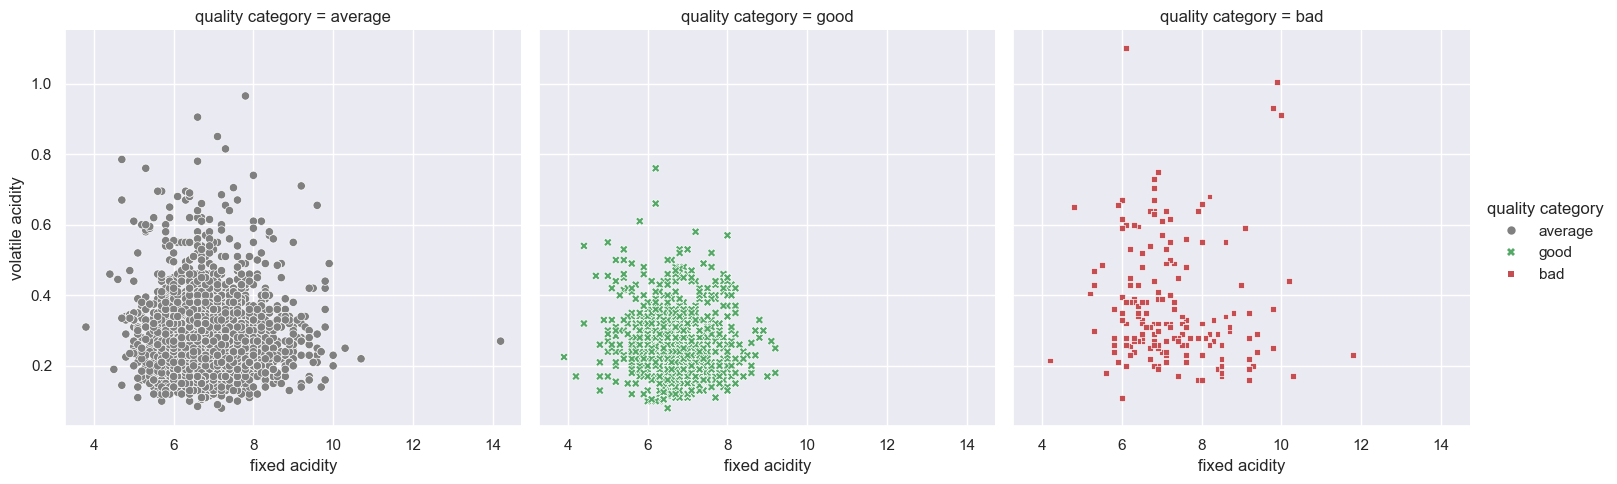

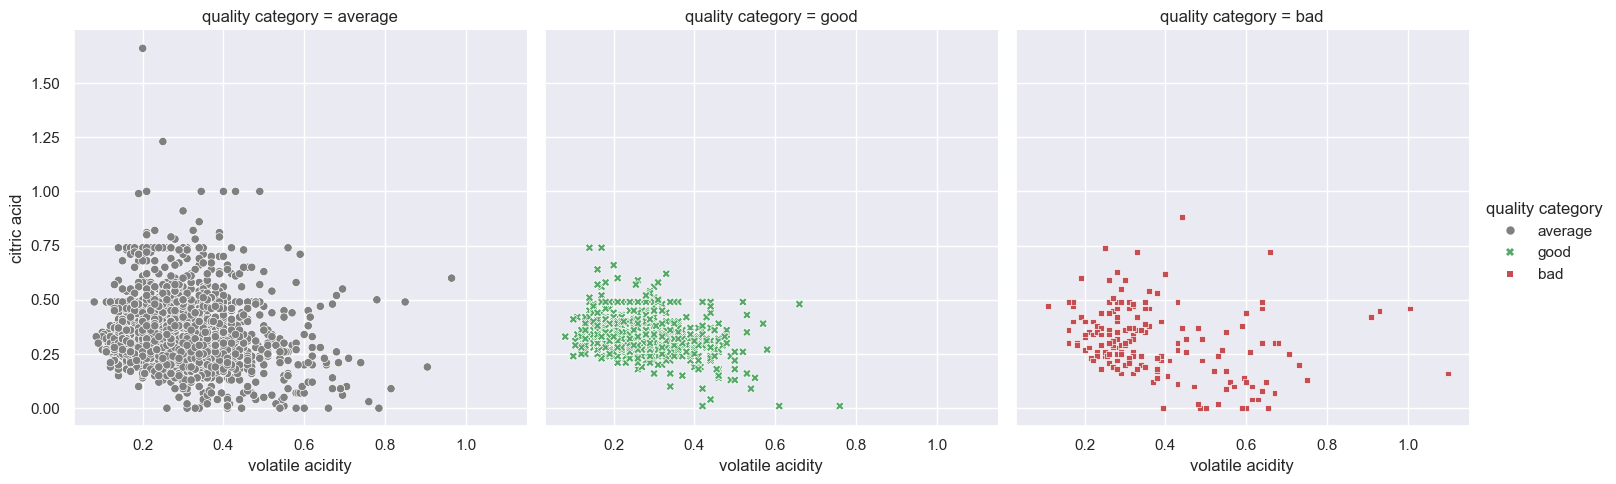

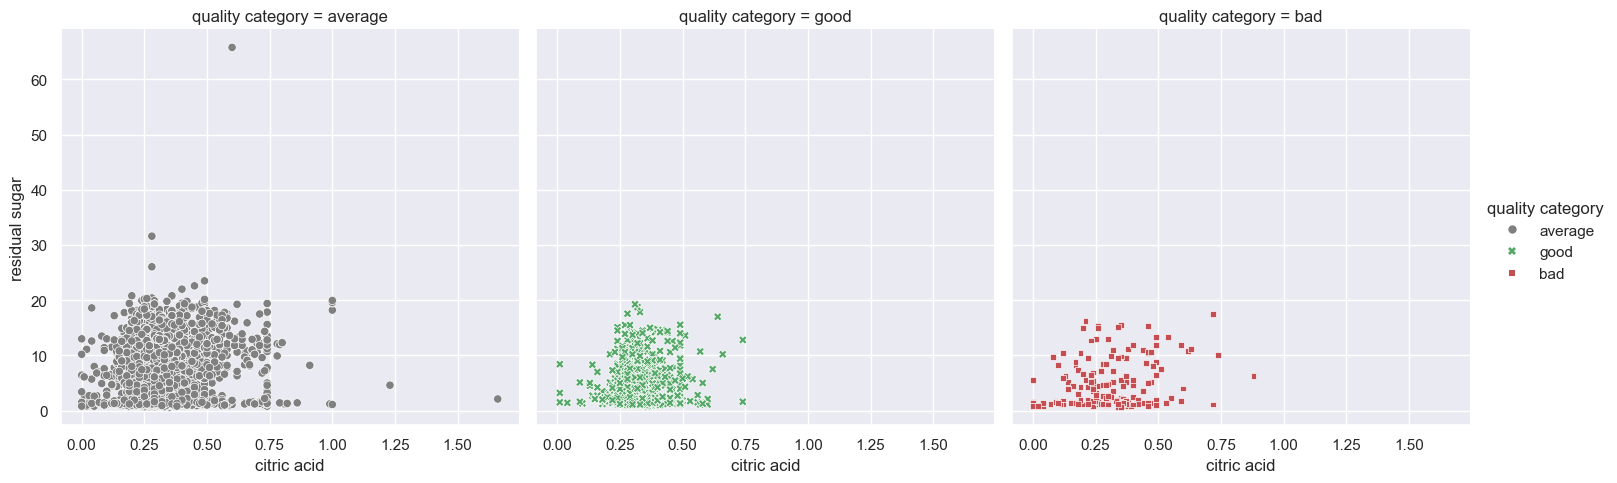

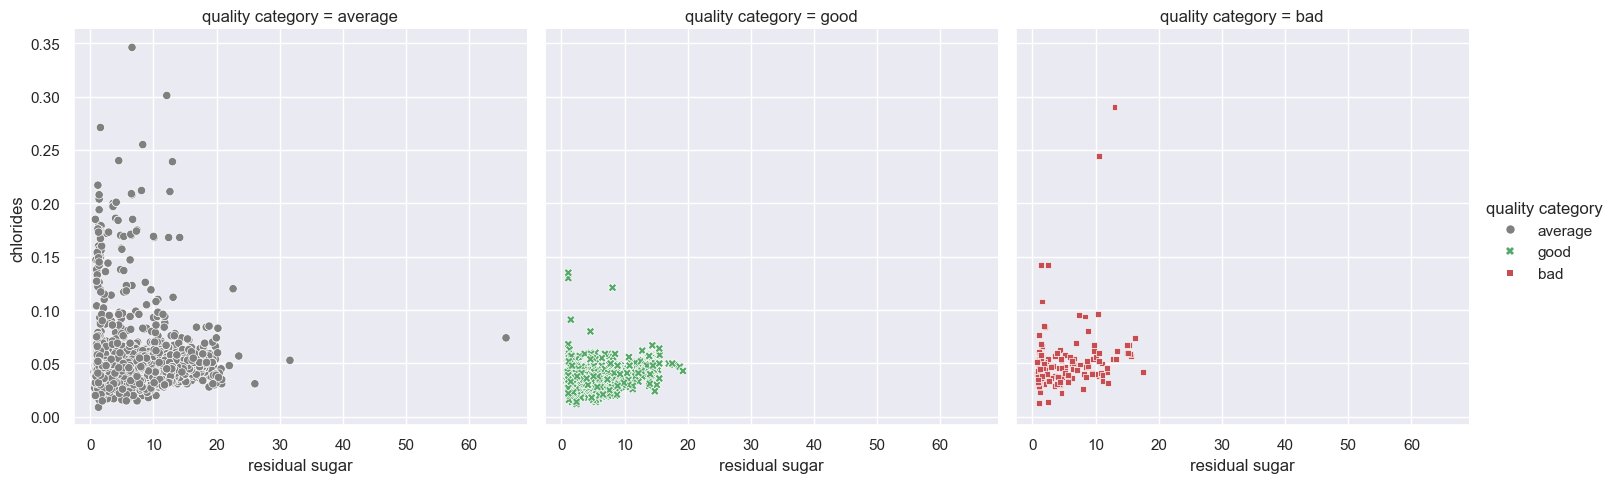

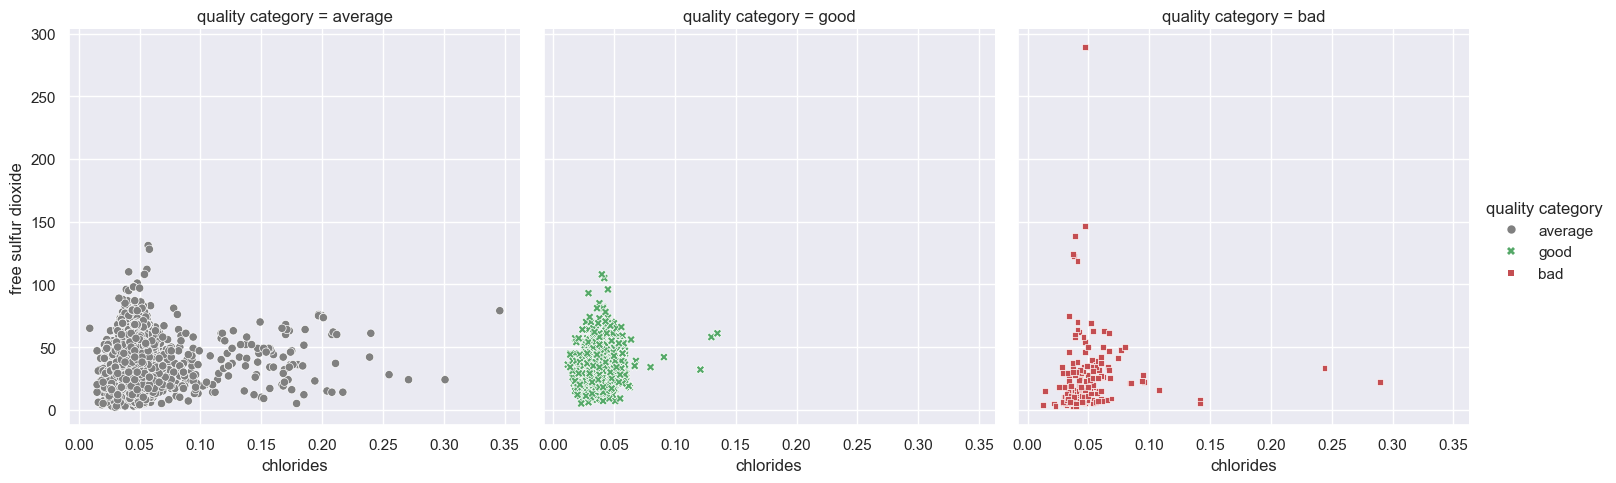

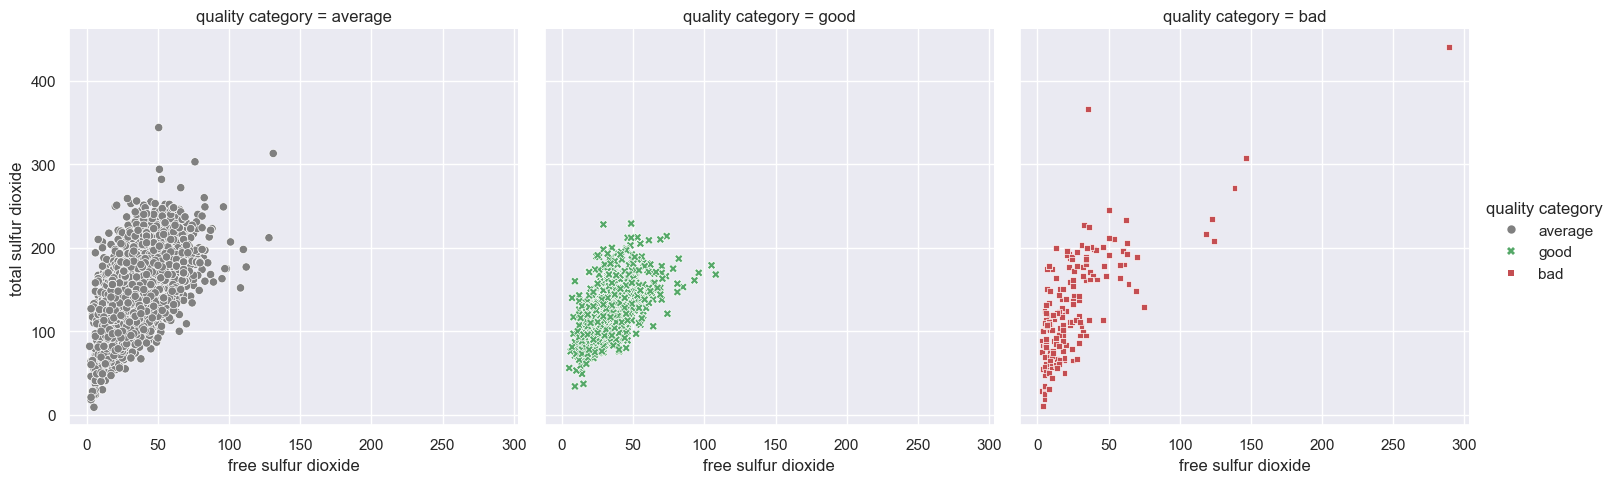

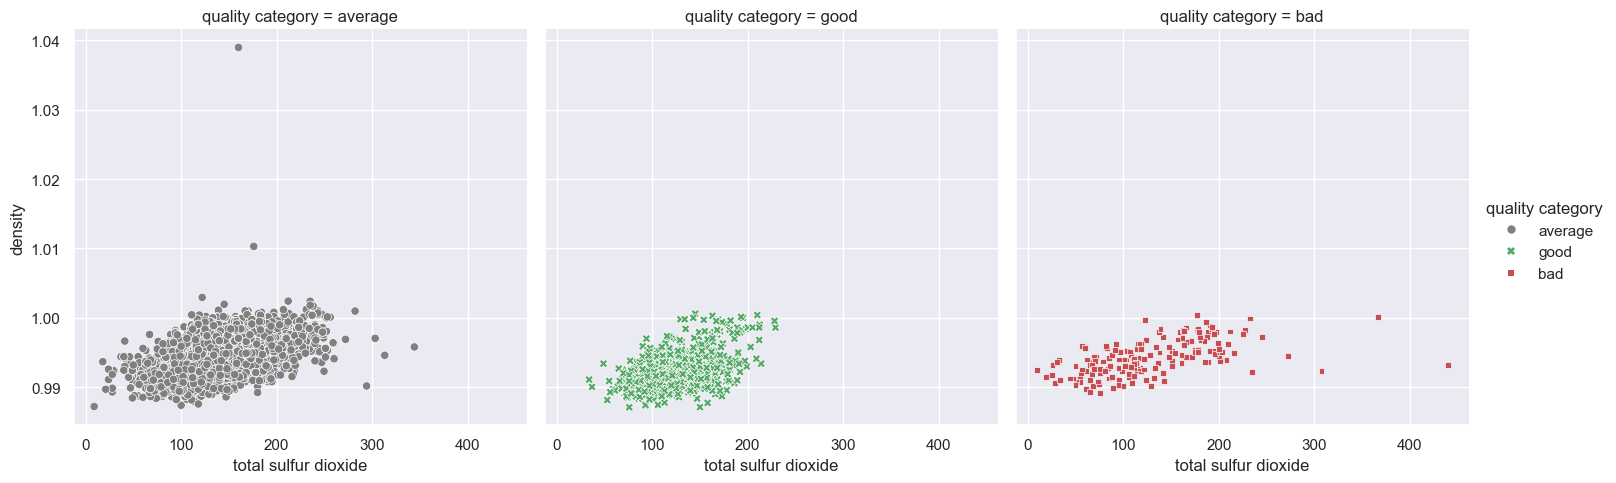

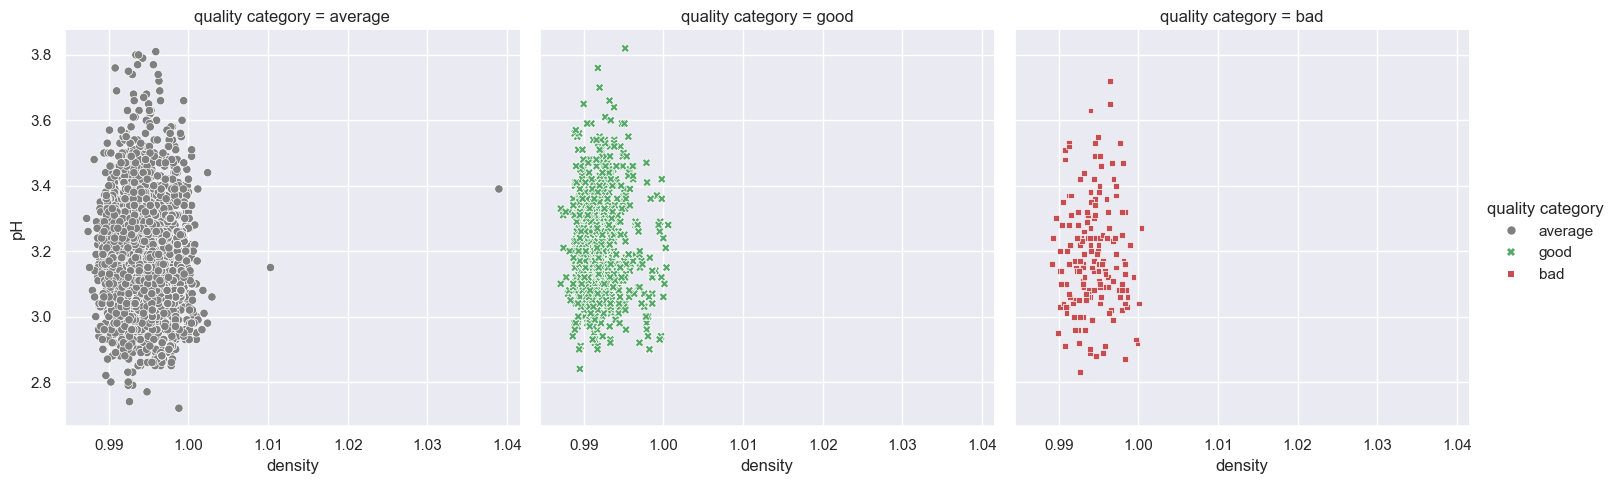

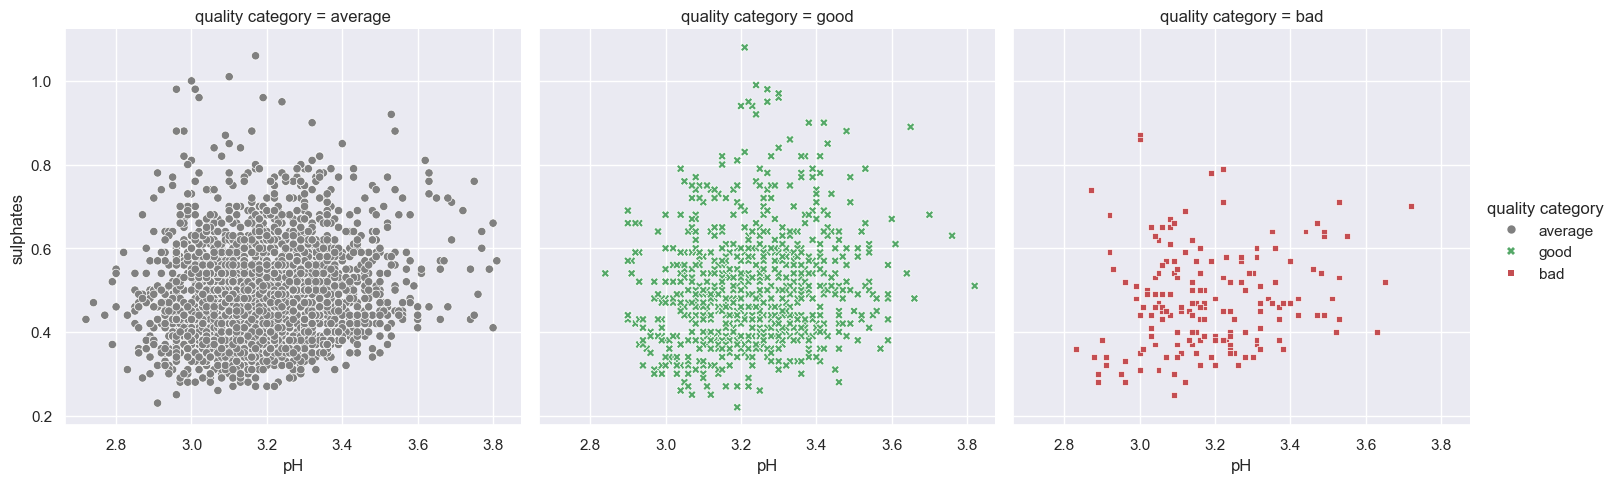

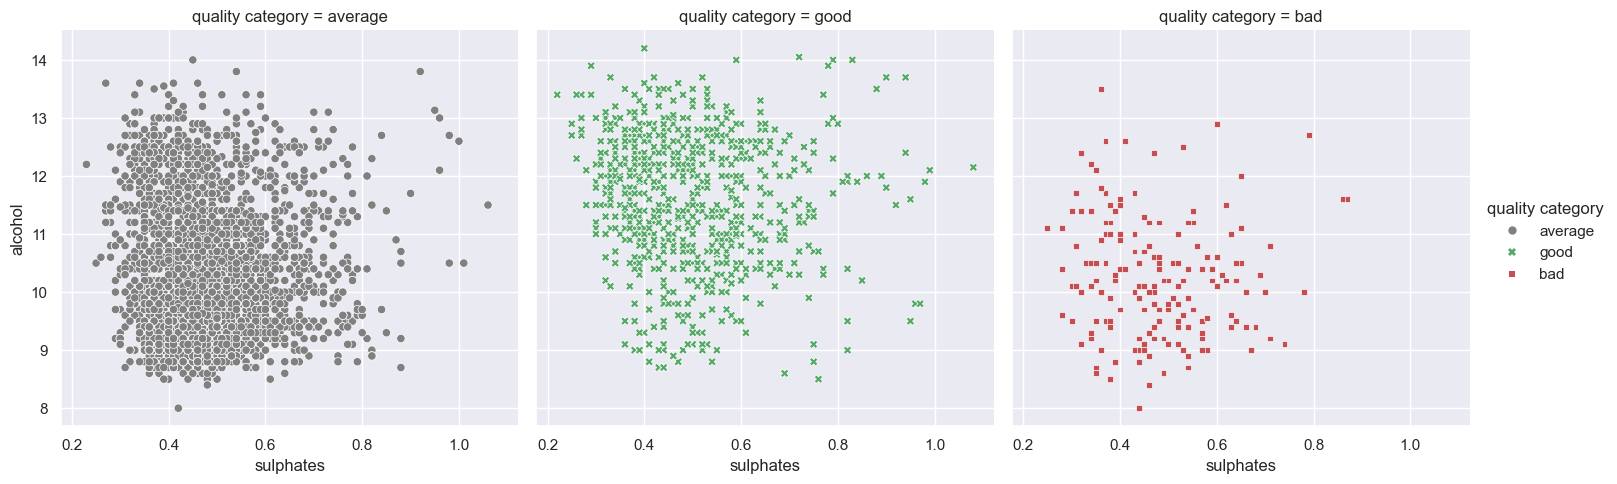

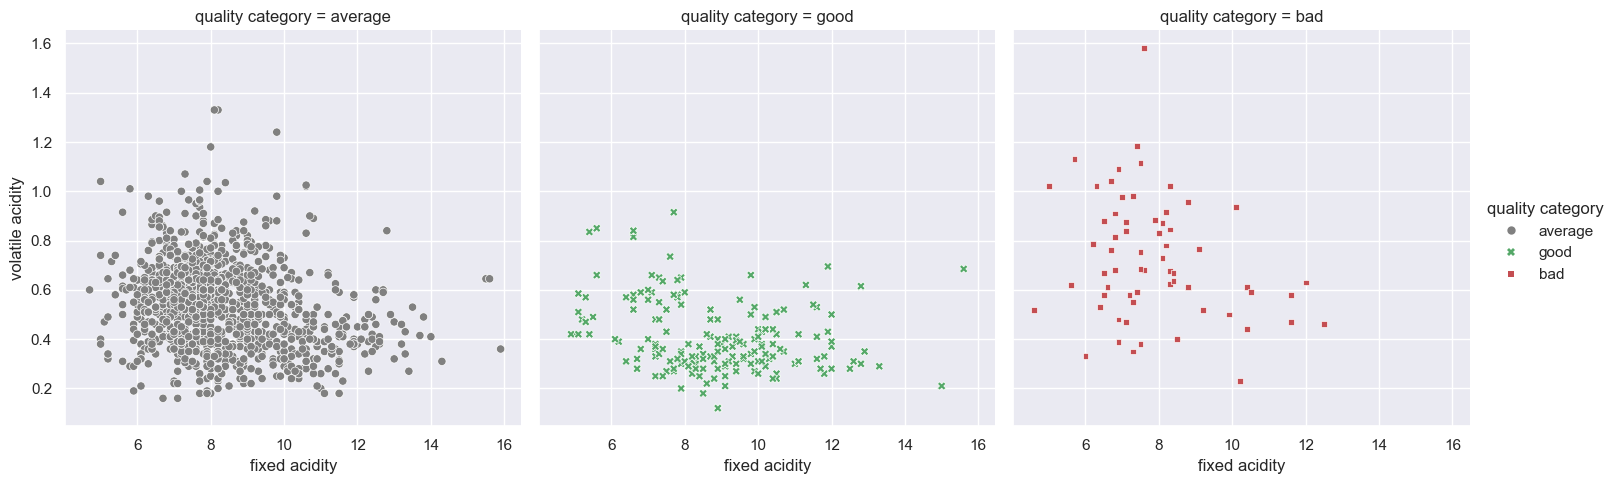

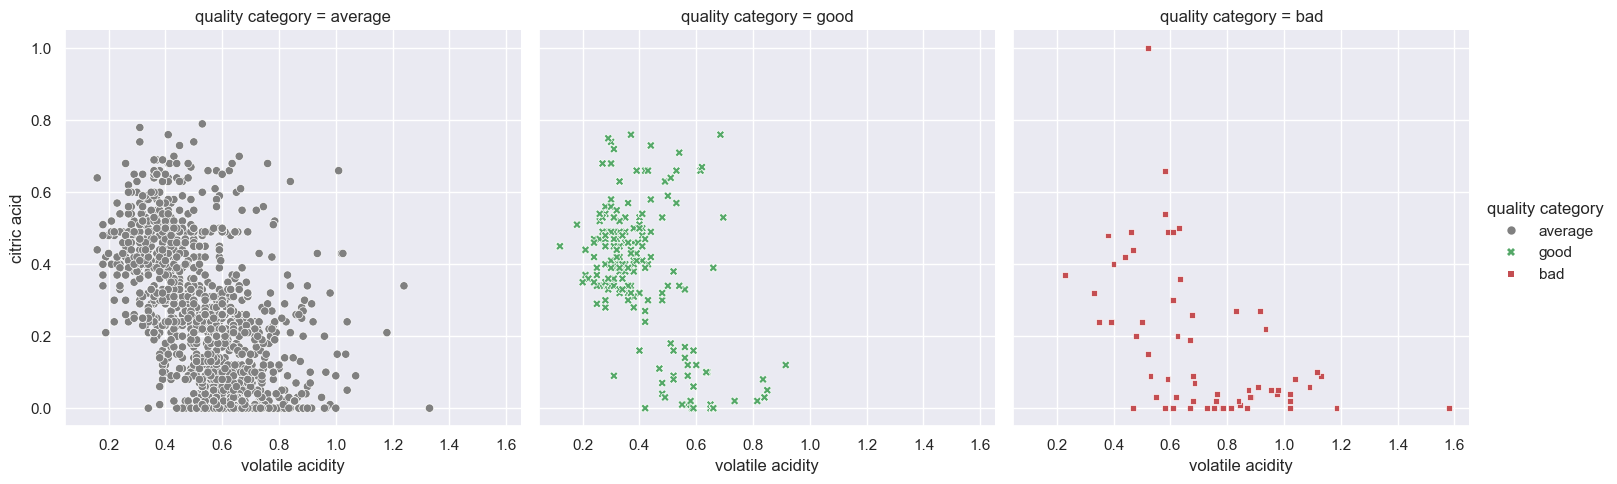

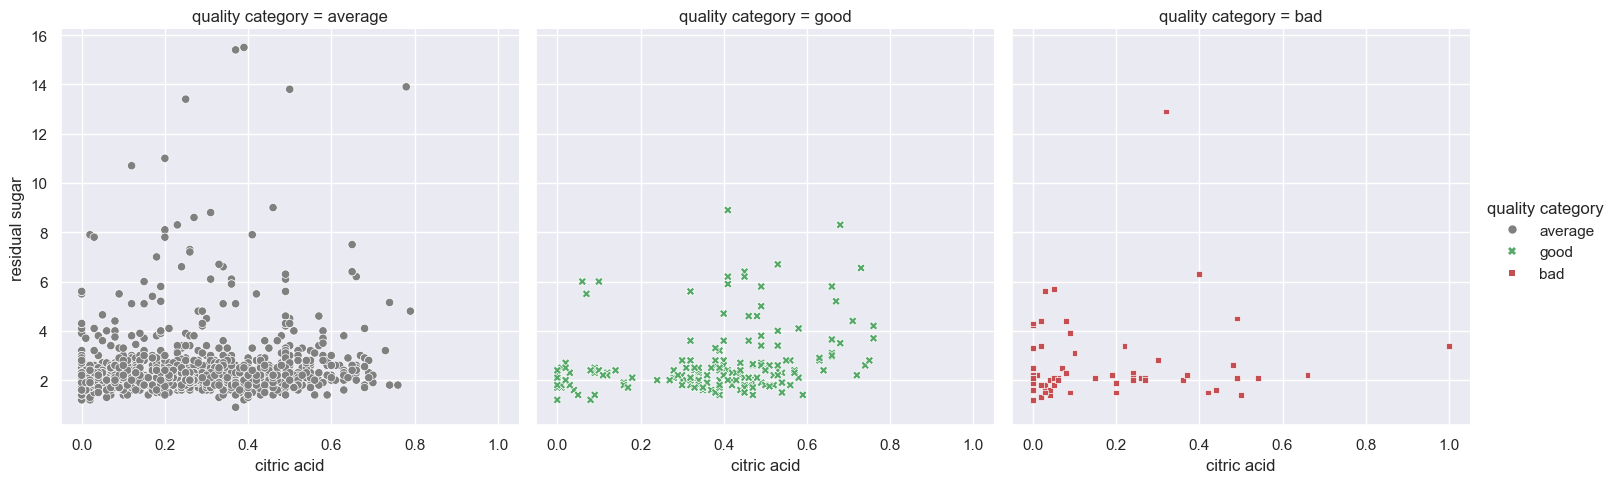

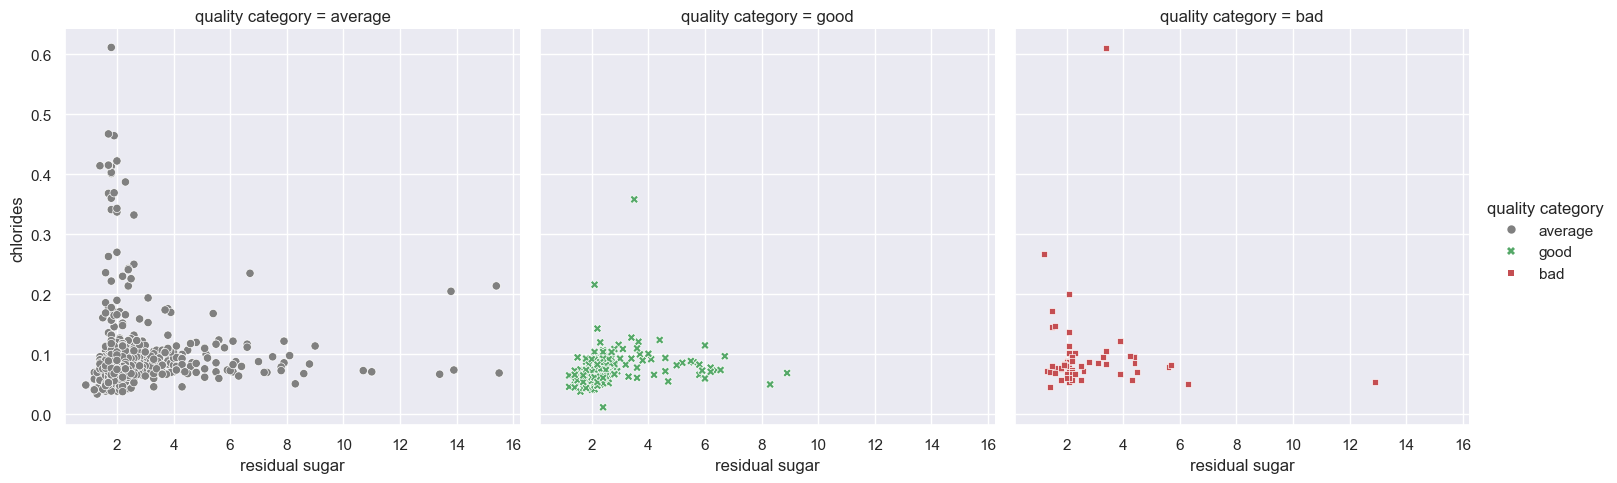

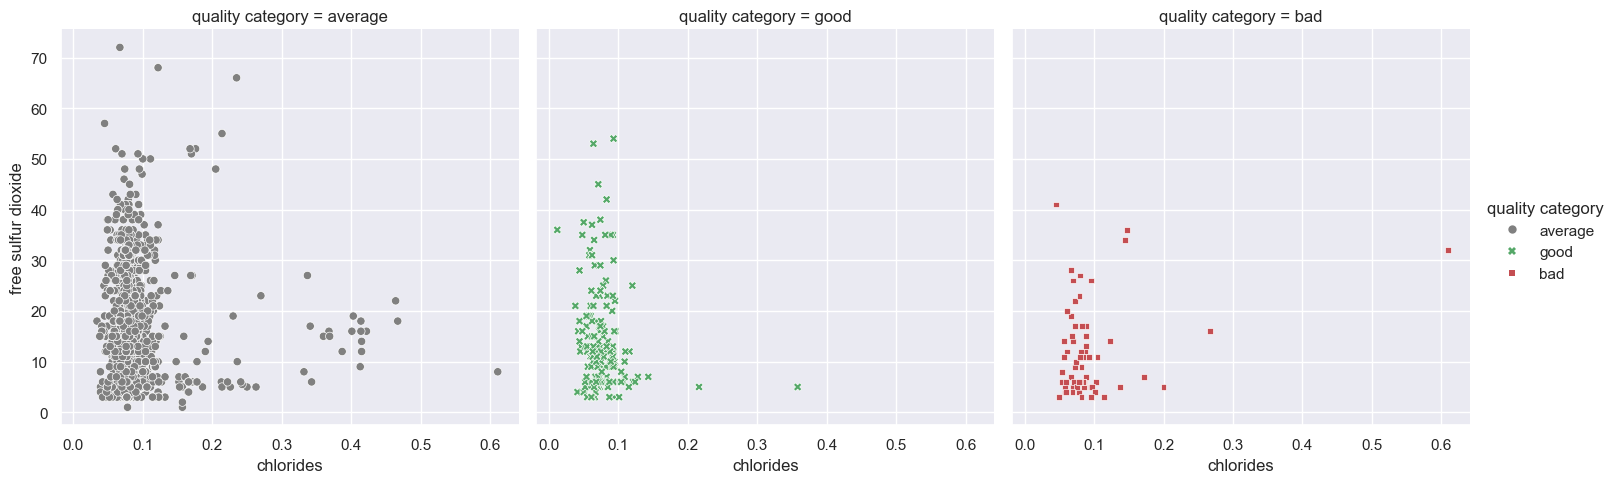

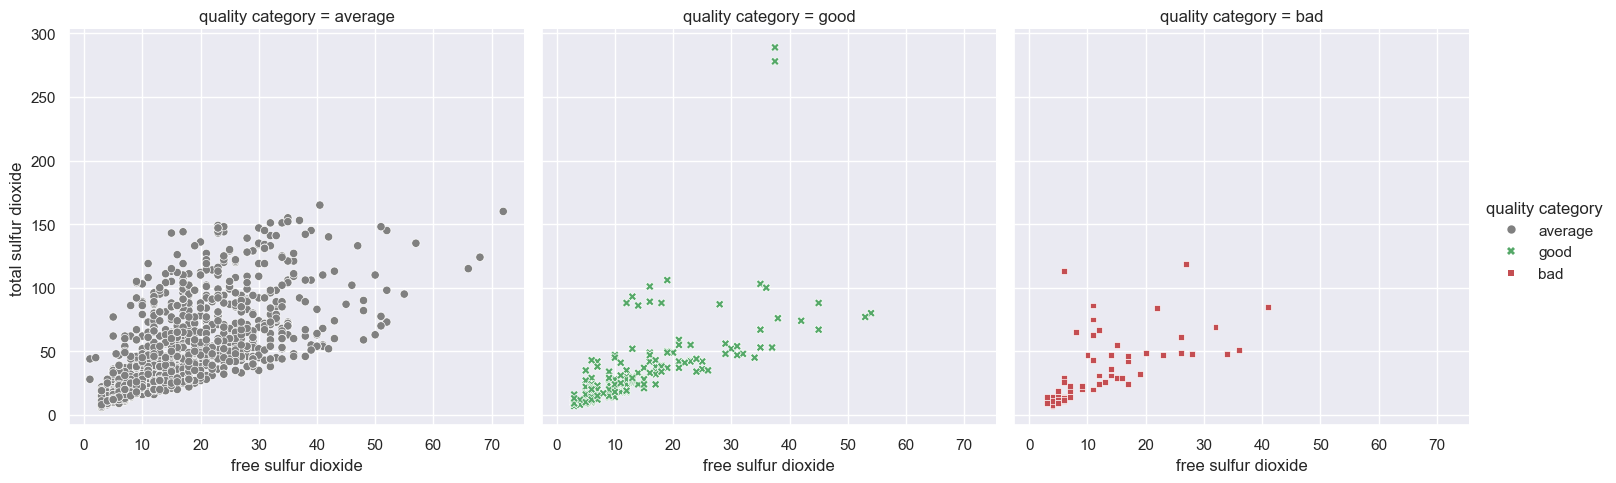

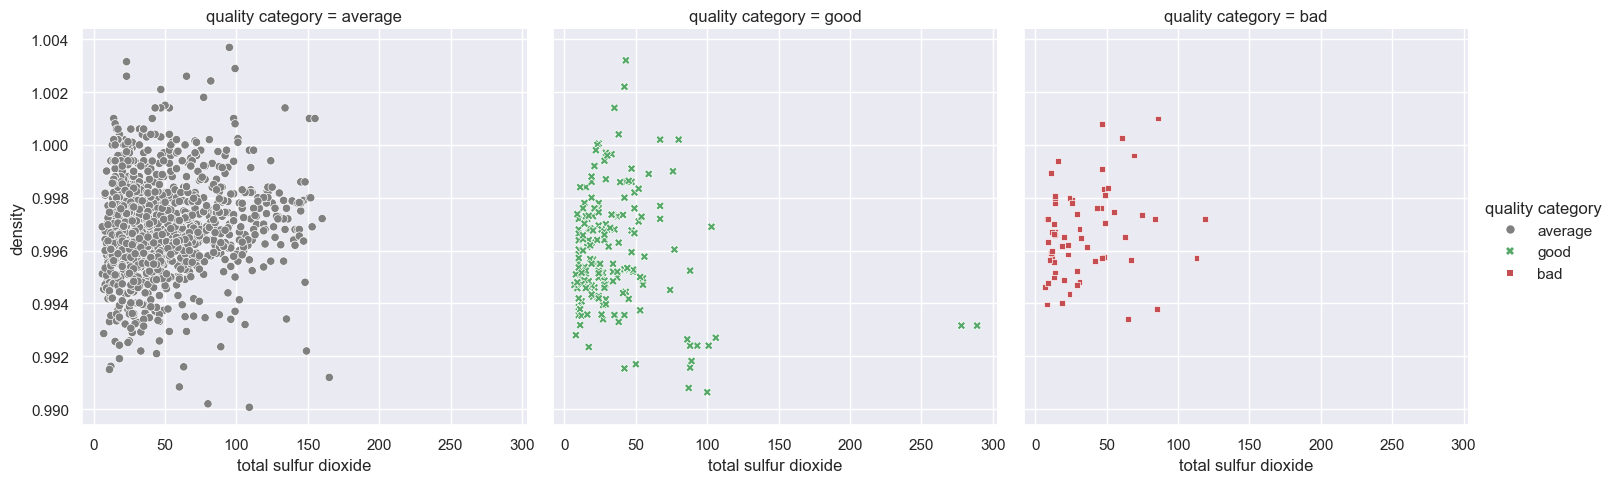

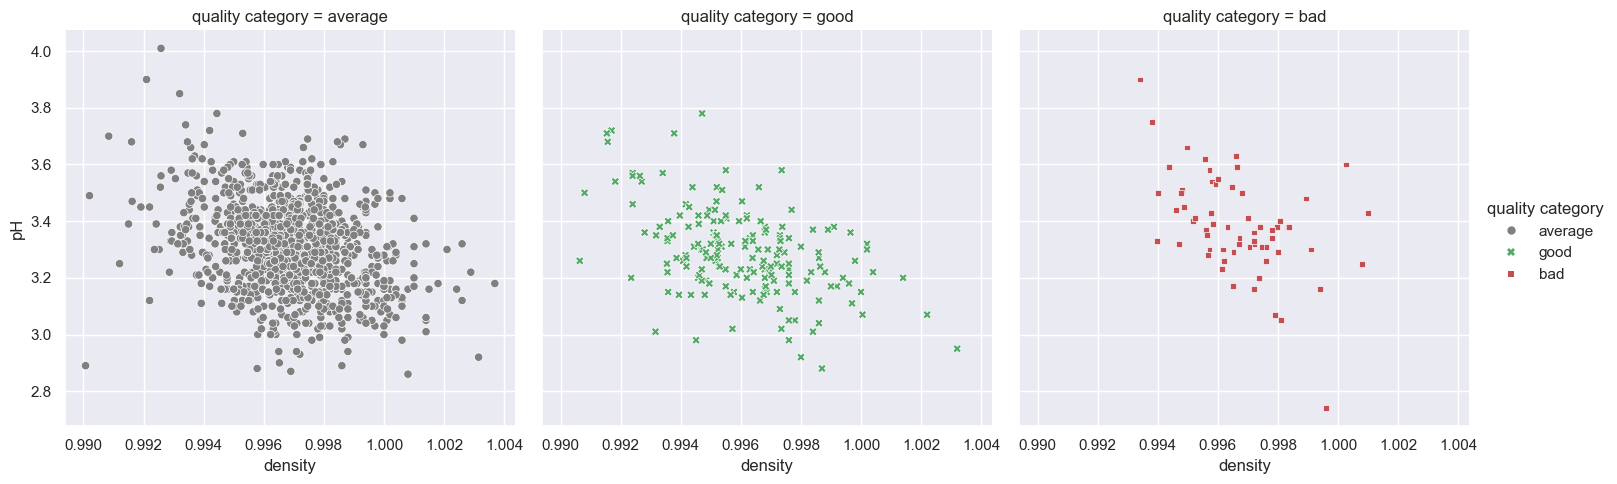

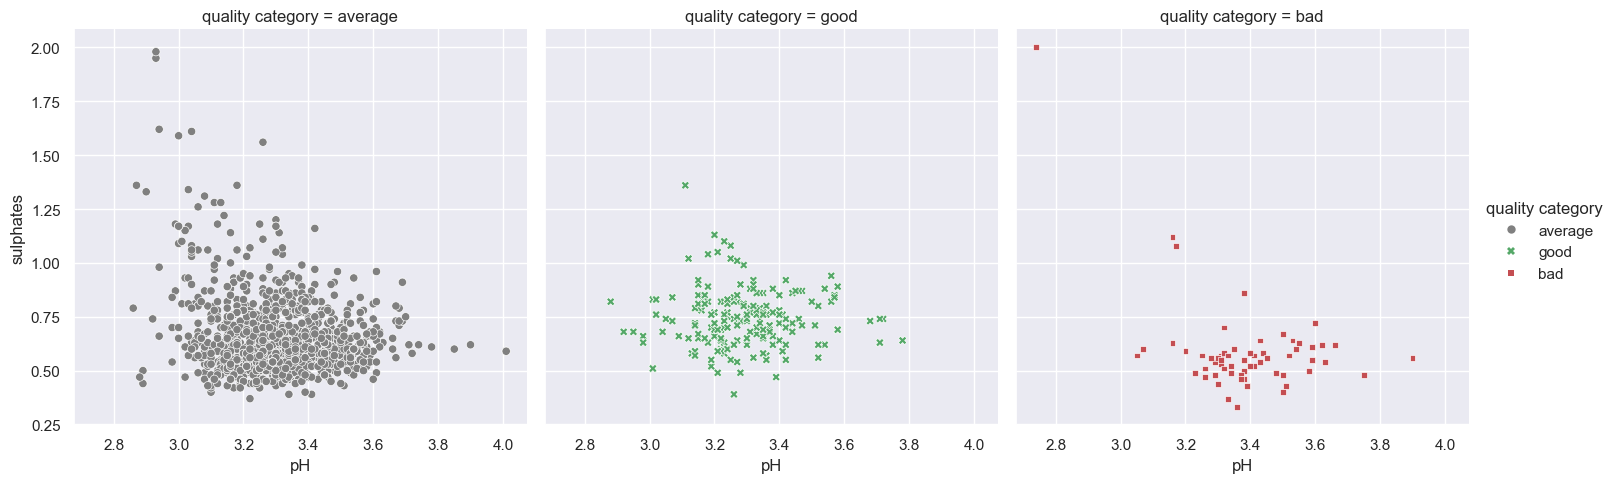

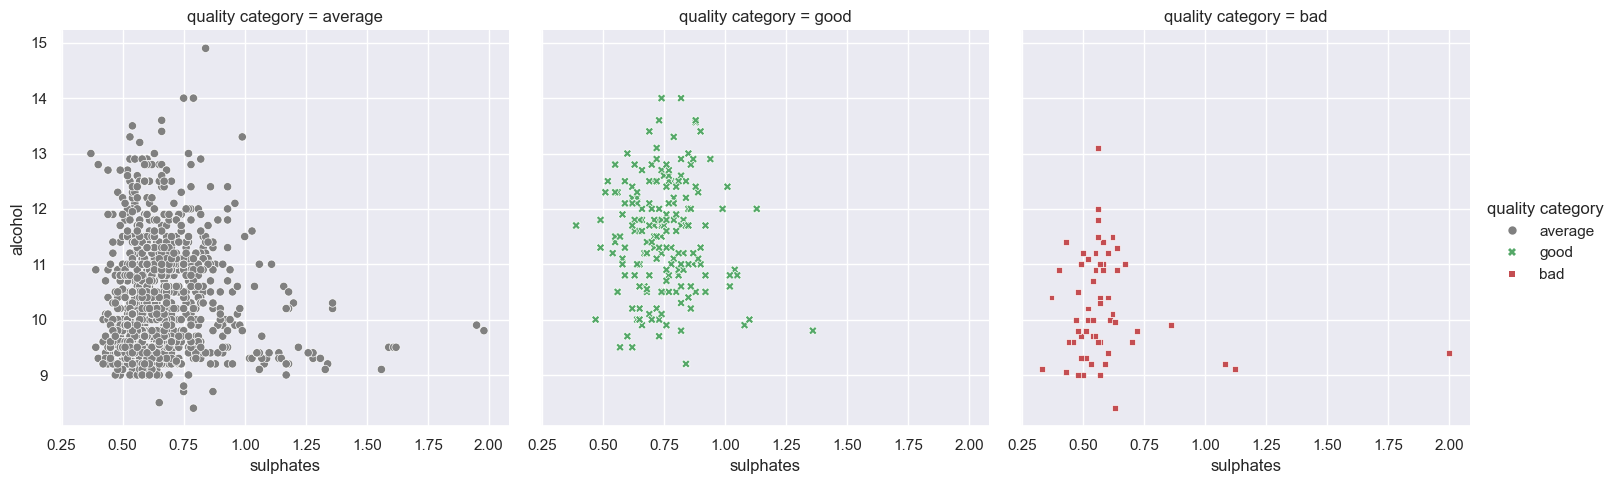

In [108]:
for color, df in zip(['white', 'red'], [white_wine_df_qc, red_wine_df_qc]):
    columns = df.columns[:-2]
    for i in range(len(columns) - 1):
        make_scatter_plots(
            df=df,
            x=columns[i],
            y=columns[i+1],
            filename=PROJECT_ROOT / 'figures' / color / f'scatter_{i + 1}',
        )